In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

import sys
import os
import glob

ADE20K_DATA = '/gpfs01/bethge/data/ADE20K_2016_07_26'
COCO_DATA = '/gpfs01/bethge/share/mscoco/COCO'
PASCAL_VOC_DATA = '/gpfs01/bethge/data/PascalVOC'
MASK_RCNN_MODEL_PATH = '/gpfs01/bethge/home/iustyuzh/siamese-mask-rcnn/Mask_RCNN/'
SIAMESE_MASK_RCNN_PATH = '/gpfs01/bethge/home/iustyuzh/siamese-mask-rcnn/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
if SIAMESE_MASK_RCNN_PATH not in sys.path:
    sys.path.append(SIAMESE_MASK_RCNN_PATH)
    
from samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
import utils as siamese_utils
import model as siamese_model
import siamese_mrcnn_models as model_zoo
    
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
from IPython import display
from collections import defaultdict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [2]:
class TrainConfig(coco.CocoConfig):
    # Reduced image sizes
    TARGET_MAX_DIM = 96
    TARGET_MIN_DIM = 75
    IMAGE_MIN_DIM = 400
    IMAGE_MAX_DIM = 512
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  400
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [3]:
coco_val = siamese_utils.IndexedCocoDataset()
coco_val.load_coco(COCO_DATA, "val", year="2017")
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = np.array(range(1,81))

loading annotations into memory...
Done (t=1.45s)
creating index...
index created!


In [4]:
image_ids = coco_val.image_ids

In [25]:
from choose_evaluation_instances import run_insatances_selection

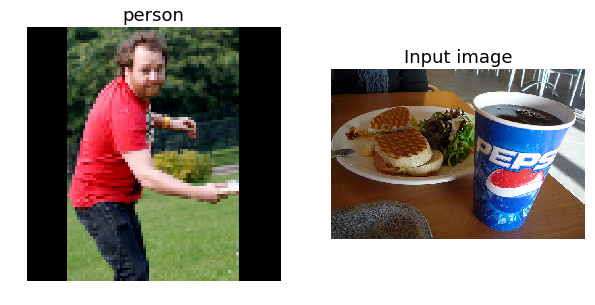

KeyboardInterrupt: 

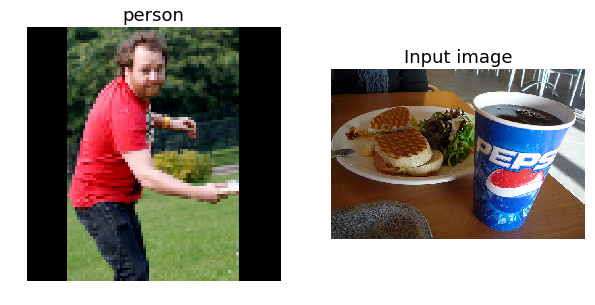

In [26]:
run_insatances_selection(coco_val, config, 'evaluation_instances/coco')

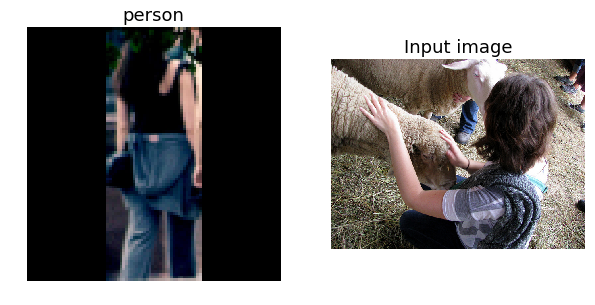

KeyboardInterrupt: 

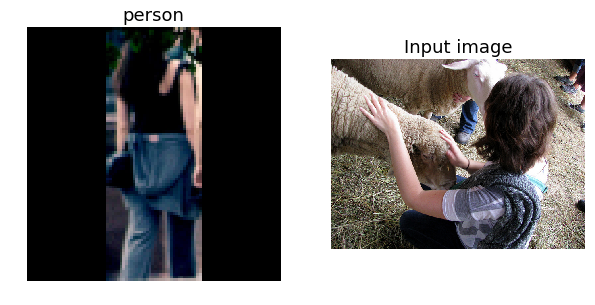

In [23]:
plt.figure(figsize=(10, 5))

for i, image_id in enumerate(image_ids):
    coco_image_id = coco_val.image_info[image_id]["id"]
    
    save_filename = '{}.pkl'.format(coco_image_id)
    if os.path.isfile(save_filename):
        continue
    
    coco_val_instances = {}
    image = coco_val.load_image(image_id)
    
    gt_class_ids = coco_val.load_mask(image_id)[1]
    if not np.any(gt_class_ids > 0):
            continue
            
    categories = np.unique(gt_class_ids)
    _idx = categories > 0
    categories = categories[_idx]
    
    for category in categories:
        while True:
            try:
                target, target_size = siamese_utils.get_one_target(category, coco_val, config, return_original_size=True)
            except:
                print('Error extracting target. Imade ID {}, category {}'.format(image_id, category))
                
            if max(target_size[:2]) < 20:
                continue

            plt.subplot(1,2,1)
            plt.imshow(target)
            plt.title(coco_val.class_names[category], fontsize=18)
            plt.axis('off')

            plt.subplot(1,2,2)
            plt.imshow(image)
            plt.title('Input image', fontsize=18)
            plt.axis('off')

            display.display(plt.gcf())
            
            target_chosen = False

            while True:
                user_input = input()

                if user_input == 'n':
                    target_chosen = False
                    display.clear_output(wait=True)
                    break
                elif user_input == 'y':
                    print('Accepted. Imade ID {}, category {}'.format(coco_image_id, category))
                    coco_val_instances[category] = target
                    target_chosen = True
                    display.clear_output(wait=True)
                    break
                else:
                    print('Type y/n to accept/reject the target')
                    
            if target_chosen:
                break
                
    with open(save_filename, 'wb') as f:
        pickle.dump(coco_val_instances, f)

In [10]:
target_size

(274, 76, 3)

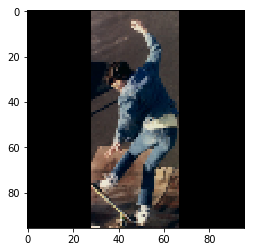

In [98]:
plt.imshow(coco_val_instances[532481][1])

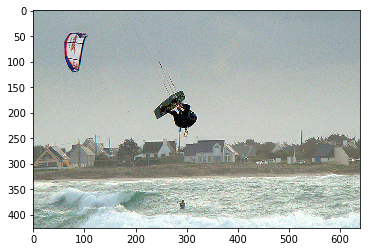

In [74]:
plt.imshow(coco_val.load_image(image_id))

In [39]:
coco_val.class_names[category]

'surfboard'

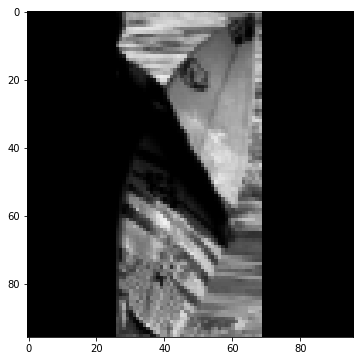

In [40]:
plt.imshow(target)

In [41]:
target.shape

(96, 96, 3)

In [5]:
coco_image_ids = [coco_val.image_info[id]["id"] for id in image_ids]

In [6]:
_, _, gt_class_ids, _, _ = modellib.load_image_gt(coco_val, config, 0, augmentation=False, use_mini_mask=config.USE_MINI_MASK)

In [7]:
gt_class_ids

array([ 1,  3,  3,  3,  3,  3,  3,  1, 34, 38], dtype=int32)

In [16]:
coco_val.load_mask(0)

(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

In [26]:
image = coco_val.load_image(10)

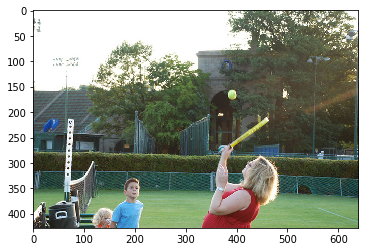

In [27]:
plt.imshow(image)